In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np

#ruta raíz
#PATH = "C:/Users/YOGA/Desktop/Alex/UP/8vo_Semestre/Robotica industrial/Proyecto/Pix2Pix"
PATH = "/content/drive/My Drive/8vo_Semestre/Robotica industrial/Proyecto/Pix2Pix"

#ruta de datos de entrada 
INPATH = PATH + '/102flowers_editada'
#ruta de datos de salida
OUTPATH = PATH + '/102flowers'
#ruta checkpoints 
CKPATH = PATH + '/checkpoints'

#imgurls = !dir /b "{INPATH}"
imgurls = !ls -1 "{INPATH}"

imgurls

# Cantidad de imágenes
n = 8000
train_n = round(n * 0.80)

#lista randomizado
randurls = np.copy(imgurls)

np.random.seed() #solo para tutorial
np.random.shuffle(randurls)

#Partición train/test
tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print(len(imgurls), len(tr_urls), len(ts_urls))


8190 6400 1600


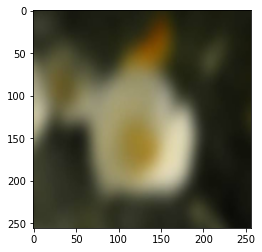

In [3]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

#reescalar imágenes
def resize(inimg, tgimg, height, width):
    inimg = tf.image.resize(inimg, [height, width])
    tgimg = tf.image.resize(tgimg, [height, width])
    
    return inimg,tgimg

#Normalizar el rango [-1, 1] la imagen
def normalize(inimg, tgimg):
    inimg = (inimg/127.5) - 1
    tgimg = (tgimg/127.5) - 1
    
    return inimg,tgimg

# Aumentación de datos : Random Crop + Flip
#Crear más fotos virtualmente, desplazando aleatorio y rotando horizontalmente
@tf.function() #compilarla fuera de eager mode de tensorflow, grafo computacional
def random_jitter(inimg,tgimg):
    inimg,tgimg = resize(inimg,tgimg,286,286)
    
    stacked_image = tf.stack([inimg, tgimg], axis = 0) #apilando imagenes una sobre otra
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3]) #2 iamgenes, altura, tamaño, 3 canales de colores
    
    inimg,tgimg = cropped_image[0], cropped_image[1]
    
    #random flip, (()) no numero escalar
    if tf.random.uniform(()) > 0.5:
        
        inimg = tf.image.flip_left_right(inimg)
        tgimg = tf.image.flip_left_right(tgimg)
        
    return inimg,tgimg

def load_images(filename, augment=True):
    inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)), tf.float32)[...,:3]
    tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH + '/' + filename)), tf.float32)[...,:3]
    
    inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)
    
    if augment:
        inimg, tgimg = random_jitter(inimg,tgimg)
    
    inimg, tgimg = normalize(inimg,tgimg)
    
    return inimg,tgimg
    
def load_train_image(filename):
    return load_images(filename, True)

def load_test_image(filename):
    return load_images(filename,False)

plt.imshow(((load_train_image(randurls[0])[0]) + 1) / 2 ) # +1 / 2 debido a que imshow va de 0 a 1

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls) #generar dataset a partir de listado
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) #mapeo entre filename con la carga de imágenes
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls) #generar dataset a partir de listado
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) #mapeo entre filename con la carga de imágenes
test_dataset = test_dataset.batch(1)

In [5]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

def downsample(filters, apply_batchnorm=True):
    
    result = Sequential() #secuencia de capaz
    
    initializer = tf.random_normal_initializer(0,0.02) #media y desviación estandar
    
    #Capa convolucional
    result.add(Conv2D(filters,
                      kernel_size=4,
                      strides=2,
                      padding="same",
                      kernel_initializer=initializer,
                      use_bias=not apply_batchnorm))
    
    if apply_batchnorm:
        #Capa de Batchnorm
        result.add(BatchNormalization())
    
    #Capa de activación
    result.add(LeakyReLU())
    
    return result

downsample(64)

In [6]:
def upsample(filters, apply_dropout=False):
    
    result = Sequential() #secuencia de capaz
    
    initializer = tf.random_normal_initializer(0,0.02) #media y desviación estandar
    
    #Capa convolucional
    result.add(Conv2DTranspose(filters,
                               kernel_size=4,
                               strides=2,
                               padding="same",
                               kernel_initializer=initializer,
                               use_bias=False))
    
    #Capa de Batchnorm
    result.add(BatchNormalization())
    
    if apply_dropout:
        #capa de dropout
        result.add(Dropout(0.5))
    
    #Capa de activación
    result.add(ReLU())
    
    return result

upsample(64)

In [0]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[None,None,3])
    
    down_stack = [
        downsample(64, apply_batchnorm=False),#(bs, 128, 128, 64)
        downsample(128),                      #(bs, 64,  64,  128)
        downsample(256),                      #(bs, 32,  32,  256)
        downsample(512),                      #(bs, 16,  16,  512)
        downsample(512),                      #(bs, 8,   8,   512)
        downsample(512),                      #(bs, 4,   4,   512)
        downsample(512),                      #(bs, 2,   2,   512)
        downsample(512),                      #(bs, 1,   1,   512)
    ]
    
    up_stack = [
        upsample(512, apply_dropout=True),  #(bs, 2,   2,   1024)
        upsample(512, apply_dropout=True),  #(bs, 4,   4,   1024)
        upsample(512, apply_dropout=True),  #(bs, 8,   8,   1024)
        upsample(512),                      #(bs, 16,  16,  1024)
        upsample(256),                      #(bs, 32,  32,  512)
        upsample(128),                      #(bs, 64,  64,  256)
        upsample(64),                       #(bs, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0,0.02) #media y desviación estandar
    
    last = Conv2DTranspose(filters = 3,
                           kernel_size=4,
                           strides=2,
                           padding="same",
                           kernel_initializer=initializer,
                           activation = "tanh")
    
    x = inputs #capas de convolución
    s = [] #skip connections
    
    concat = Concatenate()
    
    for down in down_stack:
        x = down(x)
        s.append(x)
        
    s = reversed(s[:-1])
        
    for up, sk in zip(up_stack, s):
        x = up(x)
        x = concat([x, sk])
        
    last = last(x)
    
    return Model(inputs=inputs, outputs=last)

generator = Generator()

In [0]:
def Discriminator():
    
    ini = Input(shape=[None,None,3], name="input_img")
    gen = Input(shape=[None,None,3], name="gener_img")
    
    con = concatenate([ini, gen])
    
    initializer = tf.random_normal_initializer(0,0.02) #media y desviación estandar
    
    down1 = downsample(64, apply_batchnorm=False)(con)
    down2 = downsample(128)(down1)
    down3 = downsample(256)(down2)
    down4 = downsample(1512)(down3)
    
    last = tf.keras.layers.Conv2D(filters=1,
                                kernel_size=4,
                                 strides=1,
                                 kernel_initializer=initializer,
                                 padding="same")(down4)
    
    return tf.keras.Model(inputs=[ini, gen], outputs=last)

discriminator = Discriminator()

In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
    # Diferencia entre los true por ser real y el detectado por el discriminador.
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    
    #diferencia entre lso false por ser generado y el detectado por el discriminador
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss

In [0]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    #mean abolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss

In [12]:
import os

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_prefix = os.path.join(CKPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()

AssertionError: ignored

In [0]:
def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):
    prediction = model(test_input, training=True)
    
    if save_filename:
        tf.keras.preprocessing.image.save_img(PATH + '/output/' + save_filename + '.jpg', prediction[0,...])
        
    plt.figure(figsize=(10,10))
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted_Image']
    
    if display_imgs:
        for i in range(3):
            plt.subplot(1,3, i+1)
            plt.title(title[i])
            # getting the pixel values between [0,1] to plot it
            plt.imshow(display_list[i]* 0.5+0.5)
            plt.axis('off')
            
    plt.show()

In [0]:
@tf.function
def  train_step(input_image, target):
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
        
        output_image = generator(input_image, training = True)
    
        output_gen_discr = discriminator([output_image, input_image], training = True)
    
        output_trg_discr = discriminator([target, input_image], training = True)
    
        discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)
    
        gen_loss = generator_loss(output_gen_discr, output_image, target)
        
        
        generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
        
        discriminators_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
        
        discriminator_optimizer.apply_gradients(zip(discriminators_grads, discriminator.trainable_variables))
    

In [0]:
from IPython.display import clear_output

def train(dataset, epochs):
    for epoch in range(epochs):
        imgi=0
        for input_image, target in dataset:
            print('epoch ' + str(epoch) + ' - train: ' + str(imgi)+'/'+str(len(tr_urls)))
            imgi+=1
            train_step(input_image, target)
            clear_output(wait=True)
            
        for inp, tar in test_dataset.take(5):
            generate_images(generator, inp, tar, str(imgi) + '_' + str(epoch), display_imgs=True)
            imgi+=1
        
        #saving (checkpoint) the model every 20 seconds
        if(epoch + 1) % 50 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

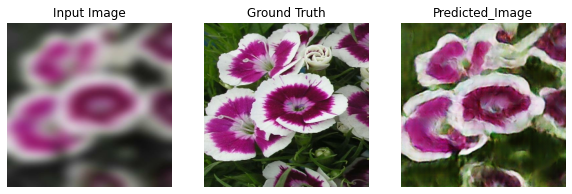

In [0]:
train(train_dataset, 100)

In [0]:
def show(dataset):

  # Cantidad de imágenes
  n = 8000
  train_n = round(n * 0.80)

  #lista randomizado
  randurls = np.copy(imgurls)

  np.random.seed() #solo para tutorial
  np.random.shuffle(randurls)

  ts_urls = randurls[train_n:n]

  test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls) #generar dataset a partir de listado
  test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) #mapeo entre filename con la carga de imágenes
  test_dataset = test_dataset.batch(1)

  imgi=0

  for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar, str(imgi), display_imgs=True)
    imgi+=1


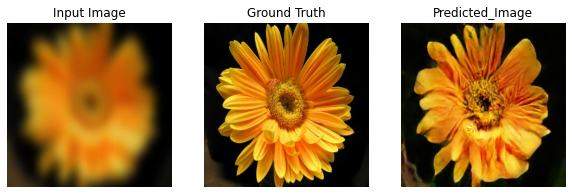

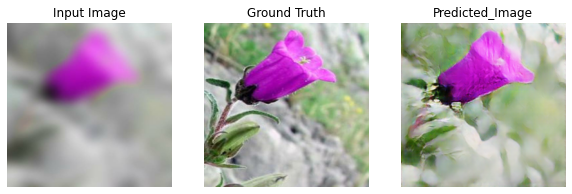

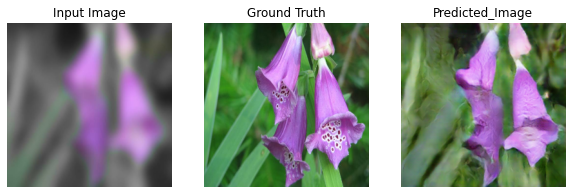

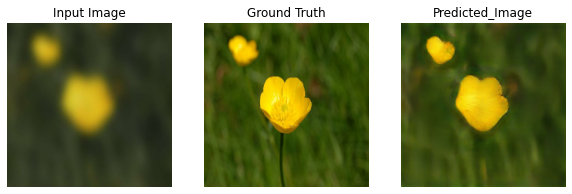

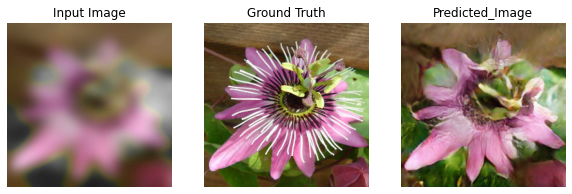

In [17]:
show(test_dataset)